# Intorduction

## Task description

Data source: Wikipedia Clickstream https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream
Prepare a Jupyter Notebook that shows how to:

1. Determine which links people click on most frequently in a given article.
2. Determine the most common referrers for a given article.
3. Determine what percentage of all visitors clicked on a link within a given article.
4. Determine and visualize the most popular articles people accessed from all external search engines.

Requirements:
1. You should create Jupyter Notebook that can be re-run to validate your tasks. Any comments in notebook or
additional readme file are welcome.
2. You are free to choose any libraries you need.
3. It would be great if you share your code, dependencies and notebook on Github or any other similar platform.

## Notebook technical aspects

Most libraries used in this notebook should be present in latest Anaconda bundle distribution (**Anaconda 5.1.0**) from [here](https://repo.continuum.io/archive/).

List of main packages used in the analysis: 


| Package     | Version     | Description                                            |
|-------------|-------------|--------------------------------------------------------|
| jupyter     | >=1.0.0     | Code interpreter in browser environment engine         |
| jupyterlab  | >=0.31.4    | Next generation notebook environment                   | 
| numpy       | >=1.14..0   | Efficient, vectorized matrix and vectror computations  |
| pandas      | >=0.22.0    | Data manipulation tool (tabular display, grouping)     |
| matplotlib  | >=2.1.2     | Basic visualization tool (2D plots)                    |
| seaborn     | >=0.8.1     | Statistical visualizations tool                        |
| watermark   | >=1.6.0     | Jupyter system info display                            |


Due to archive size I chose English Wikipedia clickstream data file from June 2018 is 314 MB in compressed form:

https://dumps.wikimedia.org/other/clickstream/2018-06/clickstream-enwiki-2018-06.tsv.gz

## Packages installation

In [ ]:
# Manual for each package
#-q quite, -U upgrade if package exists and newer is avaliable
!pip install -q -U jupyterlab numpy pandas matplotlib seaborn watermark

In [2]:
# Tool to list basic properties of the system and python environment
%load_ext watermark

In [3]:
%watermark -a "Michal Dyzma" -d -m -v -p jupyterlab,numpy,pandas,matplotlib,seaborn,watermark

Michal Dyzma 2018-07-19 

CPython 3.6.5
IPython 6.4.0

jupyterlab 0.32.1
numpy 1.14.3
pandas 0.23.0
matplotlib 2.2.2
seaborn 0.8.1
watermark 1.6.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 60 Stepping 3, GenuineIntel
CPU cores  : 4
interpreter: 64bit


# Analysis

## Data description 

https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream

For each release, and for several Wikipedia language versions, we take one months worth of requests for articles in the main namespace. Referrers are mapped to a fixed set of values, based on this scheme:

an article in the main namespace -> the article title
a page from any other Wikimedia project -> other-internal
an external search engine -> other-search
any other external site -> other-external
an empty referrer -> other-empty
anything else -> other-other

The current data includes the following 4 fields:

* prev: the result of mapping the referer URL to the fixed set of values described above
* curr: the title of the article the client requested
* type: describes (prev, curr)
    - link: if the referrer and request are both articles and the referrer links to the request
    - external: if the referrer host is not en(.m)?.wikipedia.org
    - other: if the referer and request are both articles but the referrer does not link to the request. This can happen when clients search or spoof their refer.
* n: the number of occurrences of the (referrer, resource) pair

## Load data

In [4]:
import pandas as pd
import numpy as np

In [6]:
# Download may take a while (314 MB), please be patient
data = pd.read_csv('https://dumps.wikimedia.org/other/clickstream/2018-06/clickstream-enwiki-2018-06.tsv.gz', compression='gzip', sep='\t', header=None)
data.columns= ['prev', 'curr', 'type', 'n']

In [5]:
# alternatively you can download via web browser and place in the folder with notebook
# data = pd.read_csv('clickstream-enwiki-2018-06.tsv.gz', compression='gzip', sep='\t', header=None)
# data.columns= ['prev', 'curr', 'type', 'n']

## Descriptive statistics and exploratory data analysis

In [8]:
data.head(10)

,prev,curr,type,n
0,other-other,Decian_persecution,external,17
1,Babylas_of_Antioch,Decian_persecution,link,10
2,Decius,Decian_persecution,link,82
3,other-internal,Decian_persecution,external,18
4,Roman_Empire,Decian_persecution,link,14
5,Pope_Fabian,Decian_persecution,link,32
6,Saint_Lucy,Decian_persecution,link,33
7,Origen,Decian_persecution,link,264
8,Persecution_of_Christians_in_the_Roman_Empire,Decian_persecution,link,41
9,Hypatia,Decian_persecution,link,20


In [9]:
data.describe(include='all')

,prev,curr,type,n
count,27685018,27685017,27685040,2.768504e+07
unique,1636297,4376244,3,NaN
top,other-empty,Hyphen-minus,link,NaN
freq,4115587,126087,16489512,NaN
mean,NaN,NaN,NaN,2.362320e+02
std,NaN,NaN,NaN,7.545852e+04
min,NaN,NaN,NaN,1.000000e+01
25%,NaN,NaN,NaN,1.500000e+01
50%,NaN,NaN,NaN,2.800000e+01
75%,NaN,NaN,NaN,7.500000e+01


In [10]:
# Another way of getting table (data frame object) basic composition is info method
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27685040 entries, 0 to 27685039
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int64
dtypes: int64(1), object(3)
memory usage: 844.9+ MB


In [11]:
# Any missing data?
pd.isnull(data).sum().sum()

45

Total amount of missing data in any of the columns is very low.

In [12]:
pd.isnull(data).sum().sum()/len(data) * 100

0.00016254265841768697

In [13]:
#45 Missing data I wonder which are they
data[data.isnull().any(axis=1)]

,prev,curr,type,n
1243865,NaN,Imaginary_number,link,17
2822357,NaN,Indeterminate_form,link,60
3122407,NaN,Extended_real_number_line,link,27
4195944,NaN,Nan,other,18
6061489,NaN,Zero_to_the_power_of_zero,link,32
8452761,NaN,Real_number,link,10
11967365,NaN,Hyphen-minus,other,14
13542293,NaN,Integer_overflow,link,12
17779608,NaN,Main_Page,other,20
18553454,NaN,Denormal_number,link,23


Anyway, I can safely remove 45  NaN's from the dataframe

In [14]:
data.dropna(axis=0, inplace=True)

In [15]:
data.isnull().sum().sum()

0

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27684995 entries, 0 to 27685039
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int64
dtypes: int64(1), object(3)
memory usage: 1.0+ GB


In [17]:
# Lets check if all examples  of prev, curr and type are strings
data[['prev', 'curr', 'type']].applymap(type).eq(str).all()

prev    True
curr    True
type    True
dtype: bool

In [18]:
# maximal value in n column?
print('idx: {}, value = {}, type: {}'.format(data.n.idxmax(), data.n.max(), type(data.n.max())))

idx: 17841134, value = 395349956, type: <class 'numpy.int64'>


In [19]:
#Still less than np.int32 range, which is  2147483647
395349956<2147483647

True

In [20]:
# We can optimize a bit memory usage
data['n'] = data['n'].astype('int32')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27684995 entries, 0 to 27685039
Data columns (total 4 columns):
prev    object
curr    object
type    object
n       int32
dtypes: int32(1), object(3)
memory usage: 950.5+ MB


In [22]:
print('idx: {}, value = {}, type: {}'.format(data.n.idxmax(), data.n.max(), type(data.n.max())))

idx: 17841134, value = 395349956, type: <class 'numpy.int32'>


## Determine which links people click on most frequently in a given article.

According to wiki metadata all internal sources have type link or other, only distinction is, that links are articles requested and served, while other are requested, but referer does not link to the reqauest. So in order for link to be "clickable by people it must be connecting two articles and be of type link

In [23]:
df_link = data[data['type'] == 'link']

In [24]:
# is there any other source in prev, except Unique Wiki title?
'^other*' in df_link.prev.values

False

In [25]:
df_link.head()

,prev,curr,type,n
1,Babylas_of_Antioch,Decian_persecution,link,10
2,Decius,Decian_persecution,link,82
4,Roman_Empire,Decian_persecution,link,14
5,Pope_Fabian,Decian_persecution,link,32
6,Saint_Lucy,Decian_persecution,link,33


Now, when I have links clicked from articles to articles I can group them and count frequency. I will group by curr column, since this column refers to the link requested and sum up all events recorded in n column.

In [26]:
df_link.groupby('curr').sum().sort_values('n', ascending=False)[:5]

,n
curr,
2018_FIFA_World_Cup,1900328
Deaths_in_2018,1202549
2014_FIFA_World_Cup,988879
Andy_Spade,945346
2010_FIFA_World_Cup,781793


Most frequently clicked link in Jun 2018 was ... **2018_FIFA_World_Cup**.

## Determine the most common referrers for a given article.

Referrer is any element from prev column, no matter where it came from, it always leads to the wiki article in curr column. I will just group by prev in entire dataset and sum all events denoted in n column.

In [35]:
data.groupby('prev').sum().sort_values('n', ascending=False)[:10]

,n
prev,
other-search,2.864706e+09
other-empty,1.772645e+09
other-external,1.220500e+08
other-internal,1.192836e+08
other-other,1.100574e+08
Main_Page,3.166799e+07
2018_FIFA_World_Cup,5.727654e+06
FIFA_World_Cup,2.771914e+06
2018_FIFA_World_Cup_squads,2.208307e+06


Analysis says, that in June 2018 most common referrer (2.86 bln) to wikipedia articles was group of **search engines**.

It is also worth to note, that it was 2018 World Cup seazon, and it can be seen in Wikipedia clickstream results. Wiki page about World Cup Wiki pages came up also very high (7th, 8th and 9th) in top ten referrers.

## Determine what percentage of all visitors clicked on a link within a given article.

I already calculated nuumber of links, which were served from links in df_link. Calculating percentage will be easy as: taking all events from that data frame and divide it by total number of visitors (all n summ from entire data set).

In [36]:
'Percentage of all visitors, who clicked on a link within a given article is {:.2%}'.format(df_link.n.sum()/data.n.sum())

'Percentage of all visitors, who clicked on a link within a given article is 22.88%'

Answer: **22.88%**

## Determine and visualise the most popular articles people accessed from all external search engines.

I need to get all rows containing 'other-search' in prev column. Then group by curr column (requested articles) and sort by n descending.

In [37]:
df_search = data[data['prev'].str.contains('other-search')]
# Just pre-view of the data-set
df_search.head()

,prev,curr,type,n
14,other-search,Decian_persecution,external,399
18,other-search,Hyper-Wiener_index,external,56
21,other-search,Fitzsimmons_Range,external,80
24,other-search,River_Redlake,external,20
25,other-search,Fountain_Central_High_School,external,29


In [38]:
group = df_search.groupby('curr').sum().sort_values('n', ascending=False)[:20]

In [39]:
group = group.reset_index()

In [40]:
group

,curr,n
0,XXXTentacion,6724911
1,2018_FIFA_World_Cup,6529910
2,Anthony_Bourdain,5586971
3,Kate_Spade,3972840
4,Cristiano_Ronaldo,2744483
5,List_of_FIFA_World_Cup_finals,2527964
6,Main_Page,2507953
7,FIFA_World_Cup,2272299
8,Lionel_Messi,2151952
9,Jurassic_World:_Fallen_Kingdom,1837374


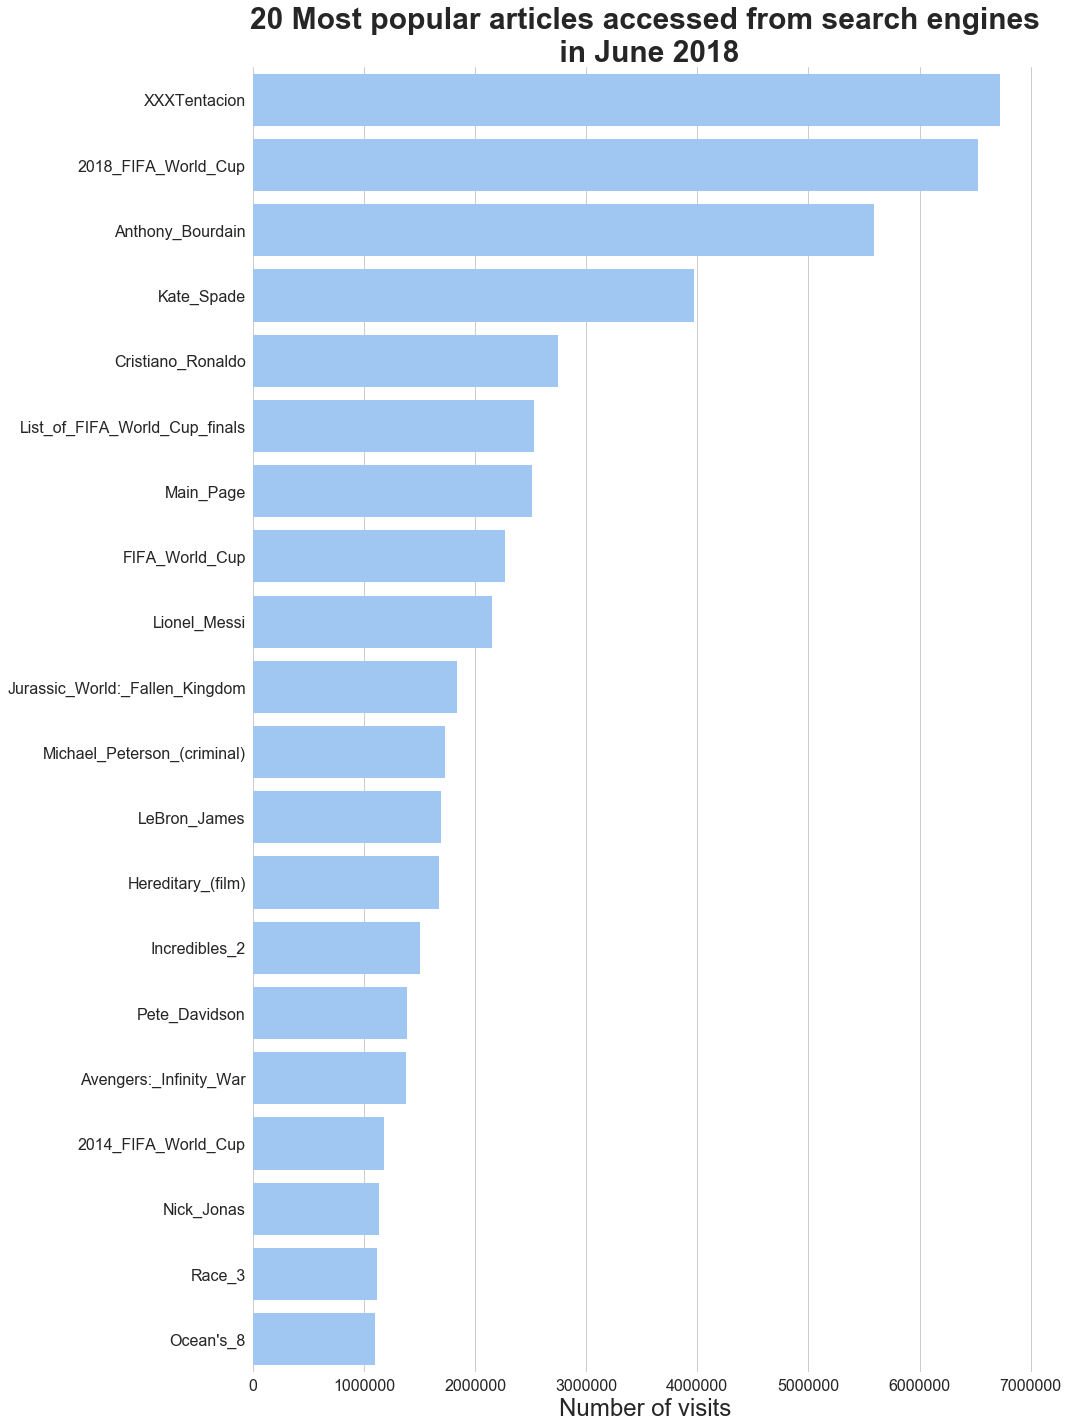

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(15, 20))

sns.set_color_codes("pastel")
sns.barplot(x="n", y="curr", data=group,
            color="b")

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
                            
ax.set_title('20 Most popular articles accessed from search engines\n in June 2018', fontdict={'fontsize':30, 'fontweight': 'bold'})

ax.set_xlabel("Number of visits", fontsize=24)
ax.set_ylabel('')
sns.despine(left=True, bottom=True)
fig.tight_layout()
fig.savefig('popular_20.png', dpi=72)


Most popular site accessed from external engines was **XXXTentacion**, page about USA raper, who was shot in June. His premature demise attracted similar numbe rof people as 2018 Fifa World Cup.